In [1]:
!pip install arabic-reshaper
!pip install python-bidi
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.9/292.9 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 32.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import re
import arabic_reshaper
from bidi.algorithm import get_display
from bs4 import BeautifulSoup
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
#Tweets about women's rights with positive sentiment scores (1.0).
df = pd.read_csv('/content/Arabic Sentiment Analysis Dataset - SS2030.csv')
df.head()

,text,Sentiment
0,حقوق المرأة 💚💚💚 https://t.co/Mzf90Ta5g1,1.0
1,RT @___IHAVENOIDEA: حقوق المرأة في الإسلام. ht...,1.0
2,RT @saud_talep: Retweeted لجنة التنمية بشبرا (...,1.0
3,RT @MojKsa: حقوق المرأة التي تضمنها لها وزارة ...,1.0
4,RT @abm112211: ولي امر الزوجة او ولي الزوجة او...,1.0


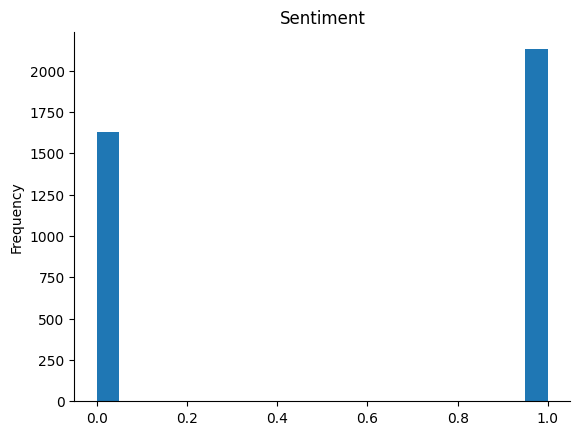

In [5]:
#Sentiment

from matplotlib import pyplot as plt
df['Sentiment'].plot(kind='hist', bins=20, title='Sentiment')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [6]:
print("\n✅ معلومات عن البيانات:")
print(df.info())

print("\n✅ الإحصائيات الوصفية:")
print(df.describe())

print("\n✅ القيم الفريدة في العمود Sentiment:")
print(df['Sentiment'].value_counts())


✅ معلومات عن البيانات:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3757 entries, 0 to 3756
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   text       3757 non-null   object 
 1   Sentiment  3756 non-null   float64
dtypes: float64(1), object(1)
memory usage: 58.8+ KB
None

✅ الإحصائيات الوصفية:
         Sentiment
count  3756.000000
mean      0.566826
std       0.495580
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000

✅ القيم الفريدة في العمود Sentiment:
Sentiment
1.0    2129
0.0    1627
Name: count, dtype: int64


In [7]:
print("\n✅ عدد القيم المفقودة:")
print(df.isnull().sum())

print("\n✅ عدد الصفوف المكررة:")
print(df.duplicated().sum())


✅ عدد القيم المفقودة:
text         0
Sentiment    1
dtype: int64

✅ عدد الصفوف المكررة:
38


/tmp/ipython-input-8-1831771733.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, palette='viridis')


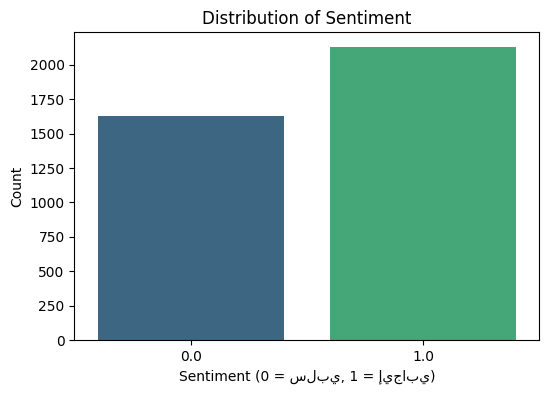

In [8]:
import seaborn as sns
# توزيع المشاعر بالرسم
plt.figure(figsize=(6,4))
sns.countplot(x='Sentiment', data=df, palette='viridis')
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment (0 = سلبي, 1 = إيجابي)')
plt.ylabel('Count')
plt.show()

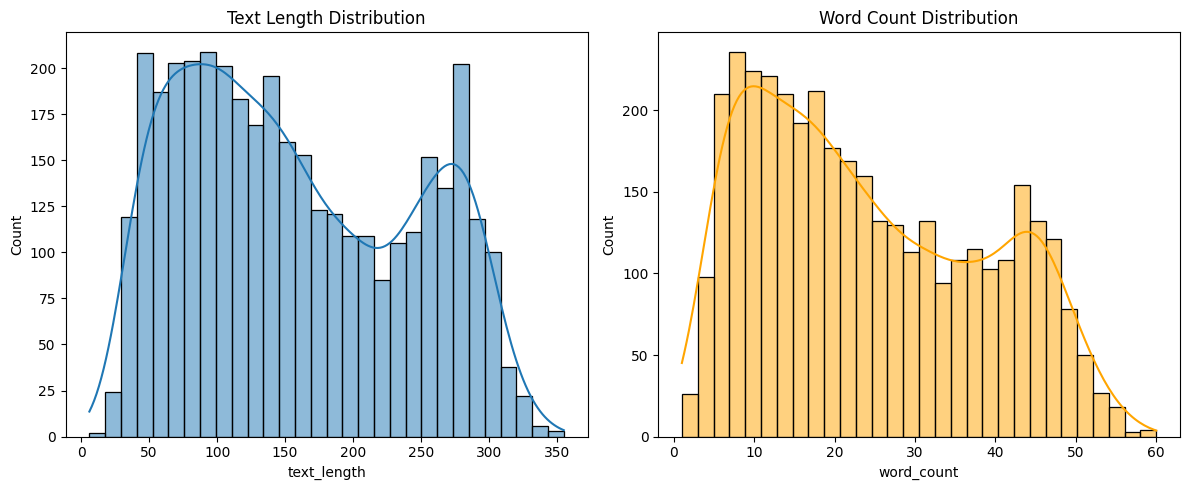

In [9]:
# تحليل طول النصوص
df['text_length'] = df['text'].astype(str).apply(len)
df['word_count'] = df['text'].astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title('Text Length Distribution')

plt.subplot(1, 2, 2)
sns.histplot(df['word_count'], bins=30, kde=True, color='orange')
plt.title('Word Count Distribution')

plt.tight_layout()
plt.show()

In [10]:
#WordCloud للكلمات الشائعة في كل فئة مشاعر

In [23]:
import re
import nltk
import emoji
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer

# تحميل كلمات التوقف
nltk.download('stopwords')
stop_words = set(stopwords.words('arabic'))

# تعريف دالة التنظيف
def clean_text(text):
    # إزالة الروابط
    text = re.sub(r'https?://\S+|www\.\S+', '', text, flags=re.MULTILINE)
    # إزالة الإيموجي
    text = emoji.replace_emoji(text, replace='')
    # إزالة الأرقام
    text = re.sub(r'\d+', '', text)
    # إزالة الرموز الخاصة
    text = re.sub(r'[^\w\s]', '', text)
    # حذف الهاشتاجات و mentions
    text = re.sub(r"[@#]\S+", '', text)
    # إزالة التشكيل (الحركات)
    text = re.sub(r'[\u064B-\u065F]', '', text)
    # إزالة التطويل
    text = re.sub(r'ـ', '', text)
    # توحيد الألف
    text = re.sub(r"[إأآ]", 'ا', text)
    # توحيد الكتابة (ى → ا, ة → ت)
    text = text.replace('ى', 'ا').replace('ة', 'ت')
    # إزالة التكرار الزائد في الحروف
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    # إزالة علامات الترقيم
    text = re.sub(r"[،«»…“”]", ' ', text)

    # إزالة كلمات التوقف
    words = text.split()
    words = [word for word in words if word not in stop_words]

    # استماتة
    stemmer = ISRIStemmer()
    words = [stemmer.stem(word) for word in words]

    # إعادة تجميع النص
    return ' '.join(words)

# تطبيق التنظيف على العمود
df['cleaned_text'] = df['text'].astype(str).apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
from wordcloud import WordCloud
import arabic_reshaper
from bidi.algorithm import get_display
def generate_wordcloud(text_series, title):
    text = ' '.join(text_series.dropna().astype(str))
    text = clean_text(text)

    if not text.strip():
        print(f"⚠️ لا يوجد نص صالح لإنشاء WordCloud لفئة: {title}")
        return

    reshaped_text = arabic_reshaper.reshape(text)
    bidi_text = get_display(reshaped_text)

    wordcloud = WordCloud(
        font_path='/content/Amiri-Regular.ttf',
        background_color='white',
        width=800,
        height=400
    ).generate(bidi_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

Sentiment
1.0    2129
0.0    1627
Name: count, dtype: int64


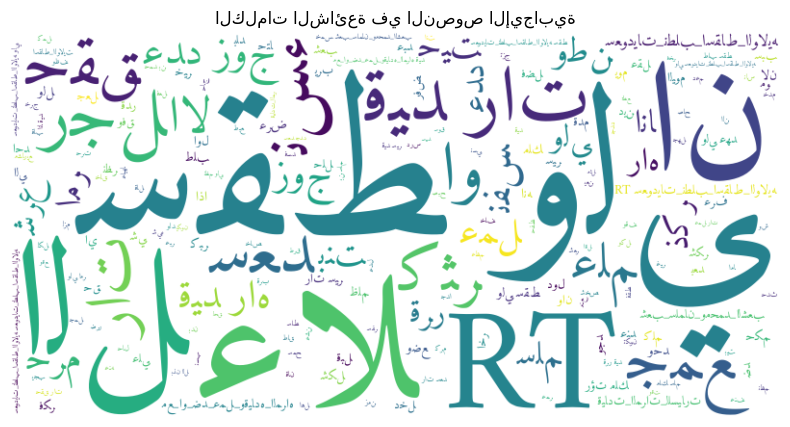

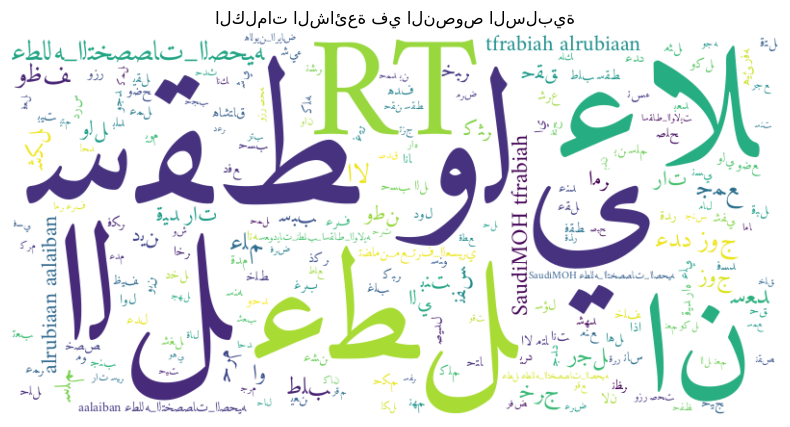

In [25]:
print(df['Sentiment'].value_counts())

# فقط نفذ WordCloud إذا وُجدت عينات كافية
if (df['Sentiment'] == 1).sum() > 0:
    generate_wordcloud(df[df['Sentiment'] == 1]['text'], 'الكلمات الشائعة في النصوص الإيجابية')

if (df['Sentiment'] == 0).sum() > 0:
    generate_wordcloud(df[df['Sentiment'] == 0]['text'], 'الكلمات الشائعة في النصوص السلبية')

In [18]:
# تقسيم البيانات
X = df['cleaned_text']
y = df['Sentiment']

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
# ترميز النصوص
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# ترميز المشاعر
y = to_categorical(y)

In [ ]:
# تقسيم البيانات إلى تدريب واختبار
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=10000, output_dim=64, input_length=max_length))
rnn_model.add(SimpleRNN(64, return_sequences=False))
rnn_model.add(Dense(2, activation='softmax'))

rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn_model.summary()

rnn_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.5766 - loss: 0.6665 - val_accuracy: 0.6990 - val_loss: 0.5981
Epoch 2/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8319 - loss: 0.4246 - val_accuracy: 0.7225 - val_loss: 0.6608
Epoch 3/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8715 - loss: 0.3521 - val_accuracy: 0.7768 - val_loss: 0.5727
Epoch 4/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9281 - loss: 0.2324 - val_accuracy: 0.7283 - val_loss: 0.7050
Epoch 5/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9237 - loss: 0.2288 - val_accuracy: 0.7357 - val_loss: 0.7561


In [ ]:
from tensorflow.keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=10000, output_dim=64, input_length=max_length))
lstm_model.add(LSTM(64, return_sequences=False))
lstm_model.add(Dense(2, activation='softmax'))

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.5756 - loss: 0.6870 - val_accuracy: 0.5639 - val_loss: 0.6864
Epoch 2/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.5789 - loss: 0.6827 - val_accuracy: 0.7386 - val_loss: 0.5400
Epoch 3/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.5840 - loss: 0.6902 - val_accuracy: 0.4890 - val_loss: 0.6882
Epoch 4/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5584 - loss: 0.6613 - val_accuracy: 0.5242 - val_loss: 0.6706
Epoch 5/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5550 - loss: 0.6586 - val_accuracy: 0.5639 - val_loss: 0.6714


In [ ]:
loss_rnn, acc_rnn = rnn_model.evaluate(X_test, y_test)
loss_lstm, acc_lstm = lstm_model.evaluate(X_test, y_test)

print(f"RNN Accuracy: {acc_rnn:.2f}")
print(f"LSTM Accuracy: {acc_lstm:.2f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6939 - loss: 0.9278
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5937 - loss: 0.6730
RNN Accuracy: 0.69
LSTM Accuracy: 0.59


In [ ]:
# الخطوة 1: معالجة مشكلة Overfitting
# ✨ 1. إضافة Dropout layers
# Dropout يمنع النموذج من الاعتماد الزائد على بعض الخلايا.

# ✨ 2. تقليل التعقيد (عدد الوحدات أو الطبقات)
# عدد كبير من الوحدات = قدرة عالية على التعلّم = خطر كبير للتخصيص الزائد.

# ✨ 3. استخدام EarlyStopping
# لإيقاف التدريب عند توقف التحسّن على بيانات التحقق.

In [ ]:
from sklearn.utils import class_weight
import numpy as np

# تحويل المشاعر من one-hot إلى أرقام عادية
y_integers = np.argmax(y, axis=1)

# حساب الأوزان
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights:", class_weights_dict)

Class weights: {0: np.float64(1.170704845814978), 1: np.float64(0.8727422003284072)}


In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=10000, output_dim=64, input_length=max_length))
lstm_model.add(LSTM(64, return_sequences=False))
lstm_model.add(Dropout(0.5))  # تقليل الاعتماد الزائد
lstm_model.add(Dense(2, activation='softmax'))

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

lstm_model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.4791 - loss: 0.6970 - val_accuracy: 0.5815 - val_loss: 0.6929
Epoch 2/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.5000 - loss: 0.6930 - val_accuracy: 0.4376 - val_loss: 0.6931
Epoch 3/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.4875 - loss: 0.6961 - val_accuracy: 0.6109 - val_loss: 0.6878
Epoch 4/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.6424 - loss: 0.6669 - val_accuracy: 0.7122 - val_loss: 0.6012
Epoch 5/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.7497 - loss: 0.5503 - val_accuracy: 0.6652 - val_loss: 0.6239
Epoch 6/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7224 - loss: 0.5611 - val_accuracy: 0.6769 - val_loss: 0.6099
Epoch 7/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7376 - loss: 0.5483 - val_accuracy: 0.6769 - val_loss: 0.6167


In [ ]:
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=10000, output_dim=64, input_length=max_length))
rnn_model.add(SimpleRNN(64))
rnn_model.add(Dropout(0.5))
rnn_model.add(Dense(2, activation='softmax'))

rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

rnn_model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)

Epoch 1/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4985 - loss: 0.7050 - val_accuracy: 0.5448 - val_loss: 0.6851
Epoch 2/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7026 - loss: 0.5776 - val_accuracy: 0.6094 - val_loss: 0.7039
Epoch 3/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9179 - loss: 0.2700 - val_accuracy: 0.6828 - val_loss: 0.7270
Epoch 4/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9713 - loss: 0.0956 - val_accuracy: 0.6696 - val_loss: 0.8606


In [ ]:
#GRU يشبه LSTM لكنه أخف وأسرع، ومناسب جدًا للنصوص.
from tensorflow.keras.layers import GRU

gru_model = Sequential()
gru_model.add(Embedding(input_dim=10000, output_dim=64, input_length=max_length))
gru_model.add(GRU(64))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(2, activation='softmax'))

gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

gru_model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.5649 - loss: 0.6858 - val_accuracy: 0.5639 - val_loss: 0.6860
Epoch 2/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.5621 - loss: 0.6878 - val_accuracy: 0.5639 - val_loss: 0.6853
Epoch 3/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.5616 - loss: 0.6880 - val_accuracy: 0.5639 - val_loss: 0.6850
Epoch 4/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.5821 - loss: 0.6812 - val_accuracy: 0.5639 - val_loss: 0.6849
Epoch 5/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5767 - loss: 0.6813 - val_accuracy: 0.5639 - val_loss: 0.6849
Epoch 6/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5496 - loss: 0.6871 - val_accuracy: 0.5639 - val_loss: 0.6841
Epoch 7/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.5848 - loss: 0.6794 - val_accuracy: 0.6373 - val_loss: 0.6687
Epoch 8/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.6915 - loss: 0.5820 - val_accuracy: 0.7783 - v

In [ ]:
from tensorflow.keras.layers import GRU

gru_model = Sequential()
gru_model.add(Embedding(input_dim=10000, output_dim=64, input_length=max_length))
gru_model.add(GRU(64, return_sequences=False))
gru_model.add(Dense(2, activation='softmax'))

gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
gru_model.summary()

gru_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, class_weight=class_weights_dict)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.4737 - loss: 0.6957 - val_accuracy: 0.4361 - val_loss: 0.6951
Epoch 2/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.4421 - loss: 0.6960 - val_accuracy: 0.5639 - val_loss: 0.6899
Epoch 3/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.5457 - loss: 0.6941 - val_accuracy: 0.5653 - val_loss: 0.6930
Epoch 4/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.4275 - loss: 0.6954 - val_accuracy: 0.4376 - val_loss: 0.6932
Epoch 5/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.4572 - loss: 0.6968 - val_accuracy: 0.4361 - val_loss: 0.6951


In [ ]:
from tensorflow.keras.layers import Bidirectional

bilstm_model = Sequential()
bilstm_model.add(Embedding(input_dim=10000, output_dim=64, input_length=max_length))
bilstm_model.add(Bidirectional(LSTM(64, return_sequences=False)))
bilstm_model.add(Dense(2, activation='softmax'))

bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bilstm_model.summary()

# تدريب مع class weights
bilstm_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, class_weight=class_weights_dict)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.5856 - loss: 0.6689 - val_accuracy: 0.7636 - val_loss: 0.4897
Epoch 2/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.8797 - loss: 0.3292 - val_accuracy: 0.8179 - val_loss: 0.4019
Epoch 3/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.9584 - loss: 0.1104 - val_accuracy: 0.8238 - val_loss: 0.4905
Epoch 4/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.9888 - loss: 0.0436 - val_accuracy: 0.8135 - val_loss: 0.6214
Epoch 5/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.9943 - loss: 0.0242 - val_accuracy: 0.8164 - val_loss: 0.6637


In [ ]:
loss_bilstm, acc_bilstm = bilstm_model.evaluate(X_test, y_test)
print(f"Bidirectional LSTM Accuracy: {acc_bilstm:.2f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7811 - loss: 0.7580
Bidirectional LSTM Accuracy: 0.79


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
# افترض أن لديك نصوص المعالجة في df['cleaned_text']
X_texts = df['cleaned_text'].values  # أو نصوصك الأصلية

from sklearn.model_selection import train_test_split
X_train_texts, X_test_texts, y_train_raw, y_test_raw = train_test_split(X_texts, df['Sentiment'].values, test_size=0.2, random_state=42)

# تدريب LogisticRegression على النصوص
model_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('clf', LogisticRegression(class_weight='balanced'))
])

model_lr.fit(X_train_texts, y_train_raw)
y_pred_lr = model_lr.predict(X_test_texts)

from sklearn.metrics import classification_report
print(classification_report(y_test_raw, y_pred_lr))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       349
           1       0.85      0.83      0.84       502

    accuracy                           0.81       851
   macro avg       0.81      0.81      0.81       851
weighted avg       0.82      0.81      0.81       851



In [ ]:
from sklearn.naive_bayes import MultinomialNB

model_nb = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('clf', MultinomialNB())
])

model_nb.fit(X_train_texts, y_train_raw)
y_pred_nb = model_nb.predict(X_test_texts)

print(classification_report(y_test_raw, y_pred_nb))

              precision    recall  f1-score   support

           0       0.87      0.67      0.76       349
           1       0.80      0.93      0.86       502

    accuracy                           0.82       851
   macro avg       0.84      0.80      0.81       851
weighted avg       0.83      0.82      0.82       851



In [ ]:
from sklearn.svm import LinearSVC

model_svm = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('clf', LinearSVC(class_weight='balanced'))
])

model_svm.fit(X_train_texts, y_train_raw)
y_pred_svm = model_svm.predict(X_test_texts)

print(classification_report(y_test_raw, y_pred_svm))

              precision    recall  f1-score   support

           0       0.78      0.77      0.78       349
           1       0.84      0.85      0.85       502

    accuracy                           0.82       851
   macro avg       0.81      0.81      0.81       851
weighted avg       0.82      0.82      0.82       851



In [ ]:
def predict_sentiment(text):
    cleaned = clean_text(text)
    sequence = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(sequence, maxlen=MAX_LEN)
    prediction = model_svm.predict(padded)[0][0]
    sentiment = 'إيجابي' if prediction > 0.5 else 'سلبي'
    print(f"التعليق: {text}")
    print(f"التنبؤ: {sentiment} | الثقة: {prediction:.2f}")

In [ ]:
predict_sentiment("أحببت هذا المنتج جداً، رائع!")
predict_sentiment("لم يعجبني الأداء، كان سيء للغاية.")

NameError: name 'MAX_LEN' is not defined

In [ ]:
# تنظيف النصوص
df['cleaned_text'] = df['text'].apply(clean_arabic)

# عرض أول 5 صفوف
print(df[['text', 'cleaned_text', 'Sentiment']].head())

,text,cleaned_text,Sentiment
0,حقوق المرأة 💚💚💚 https://t.co/Mzf90Ta5g1,حقوق المرأة,1
1,RT @___IHAVENOIDEA: حقوق المرأة في الإسلام. ht...,RT ___IHAVENOIDEA حقوق المرأة في الإسلام,1
2,RT @saud_talep: Retweeted لجنة التنمية بشبرا (...,RT saud_talep Retweeted لجنة التنمية بشبرا Shu...,1
3,RT @MojKsa: حقوق المرأة التي تضمنها لها وزارة ...,RT MojKsa حقوق المرأة التي تضمنها لها وزارة العدل,1
4,RT @abm112211: ولي امر الزوجة او ولي الزوجة او...,RT abm ولي امر الزوجة او ولي الزوجة او ولي الم...,1


In [ ]:
MAX_WORDS = 10000
MAX_LEN = 50

tokenizer = Tokenizer(num_words=MAX_WORDS, filters='', lower=False)
tokenizer.fit_on_texts(df['cleaned_text'])

sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN)

In [ ]:
X = padded_sequences
y = df['Sentiment'].values

# تقسيم البيانات إلى تدريب واختبار
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
    LSTM(units=64, return_sequences=False),
    Dropout(0.4),
    Dense(24, activation='relu'),
    Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=5, batch_size=32,
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.6285 - loss: nan - val_accuracy: 0.4215 - val_loss: nan
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.4370 - loss: nan - val_accuracy: 0.4215 - val_loss: nan
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.4437 - loss: nan - val_accuracy: 0.4215 - val_loss: nan
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.4275 - loss: nan - val_accuracy: 0.4215 - val_loss: nan
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.4349 - loss: nan - val_accuracy: 0.4215 - val_loss: nan


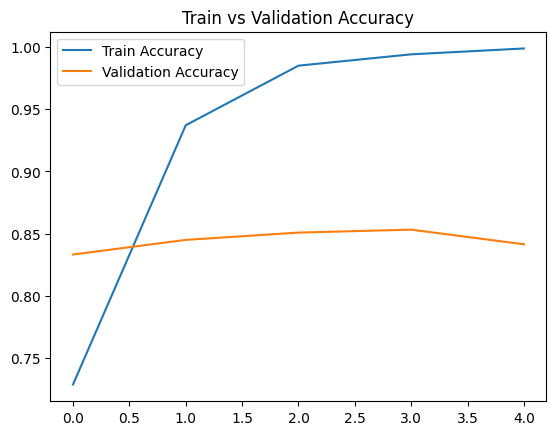

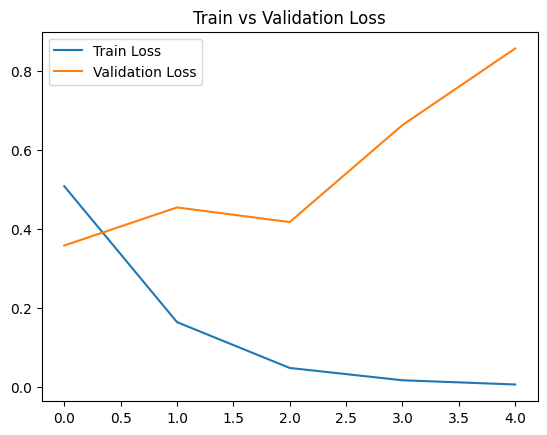

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
def predict_sentiment(text):
    cleaned = clean_text(text)
    sequence = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(sequence, maxlen=MAX_LEN)
    prediction = model.predict(padded)[0][0]
    sentiment = 'إيجابي' if prediction > 0.5 else 'سلبي'
    print(f"التعليق: {text}")
    print(f"التنبؤ: {sentiment} | الثقة: {prediction:.2f}")

In [ ]:
predict_sentiment("أحببت هذا المنتج جداً، رائع!")
predict_sentiment("لم يعجبني الأداء، كان سيء للغاية.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
التعليق: أحببت هذا المنتج جداً، رائع!
التنبؤ: سلبي | الثقة: 0.32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
التعليق: لم يعجبني الأداء، كان سيء للغاية.
التنبؤ: سلبي | الثقة: 0.07


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

model1 = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),

    # إضافة Bidirectional LSTM أولى
    Bidirectional(LSTM(units=64, return_sequences=True)),
    Dropout(0.4),

    # إضافة LSTM ثانية
    LSTM(units=32, return_sequences=False),
    Dropout(0.4),

    # طبقة كثيفة
    Dense(24, activation='relu'),
    Dropout(0.3),

    # خرج
    Dense(1, activation='sigmoid')  # binary classification
])

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history1 = model.fit(X_train, y_train, epochs=5, batch_size=32,
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.9980 - loss: 0.0086 - val_accuracy: 0.8660 - val_loss: 0.7048
Epoch 2/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9984 - loss: 0.0072 - val_accuracy: 0.8625 - val_loss: 0.8066
Epoch 3/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9995 - loss: 0.0041 - val_accuracy: 0.8578 - val_loss: 0.9263
Epoch 4/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.9995 - loss: 0.0020 - val_accuracy: 0.8637 - val_loss: 0.9785
Epoch 5/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9974 - loss: 0.0040 - val_accuracy: 0.8637 - val_loss: 1.0783


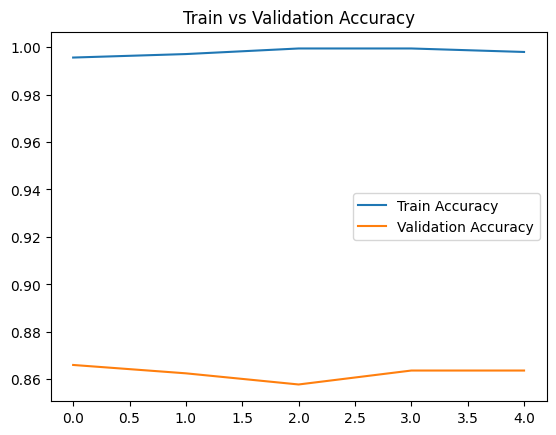

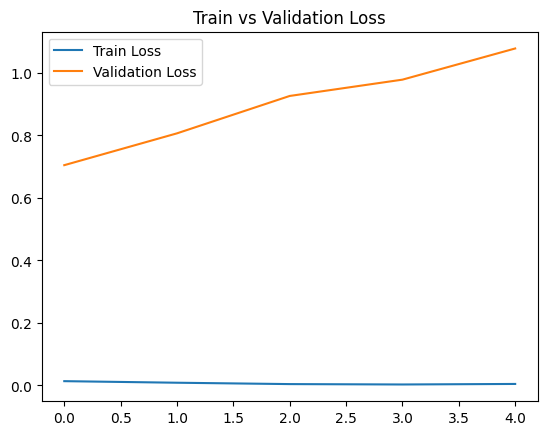

In [ ]:
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
# نصوص جديدة
new_texts = [
    "حقوق المرأة يجب أن تُحترم",
    "هذا المنتج سيء جدا ولا أنصح به",
    "الخدمة ممتازة وسريعة",
    "تجربة سيئة مع هذا التطبيق"
]

# التنبؤ
pred_lr = model_lr.predict(new_texts)
pred_svm = model_svm.predict(new_texts)

print("Logistic Regression predictions:", pred_lr)
print("SVM predictions:", pred_svm)


Logistic Regression predictions: [1 0 1 1]
SVM predictions: [1 1 1 1]


In [ ]:
from sklearn.model_selection import train_test_split

# بافتراض أن لديك DataFrame اسمه df ويحتوي على 'text' و 'Sentiment'
X = df['text'].astype(str)
y = df['Sentiment']

train_texts, val_texts, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
max_len = 60
embedding_dim = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

X_train_seq = tokenizer.texts_to_sequences(train_texts)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')

X_val_seq = tokenizer.texts_to_sequences(val_texts)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
model.add(Bidirectional(LSTM(units=128)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_val_pad, y_val))

Epoch 1/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 346ms/step - accuracy: 0.5737 - loss: 0.6715 - val_accuracy: 0.7356 - val_loss: 0.5580
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 363ms/step - accuracy: 0.8498 - loss: 0.3404 - val_accuracy: 0.8331 - val_loss: 0.4286
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 270ms/step - accuracy: 0.9535 - loss: 0.1214 - val_accuracy: 0.8014 - val_loss: 0.5895
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 266ms/step - accuracy: 0.9838 - loss: 0.0524 - val_accuracy: 0.8026 - val_loss: 0.7936
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 262ms/step - accuracy: 0.9881 - loss: 0.0336 - val_accuracy: 0.8155 - val_loss: 0.8299


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# إنشاء tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_texts)  # درب tokenizer على نصوص التدريب

# ترميز نص جديد
new_texts = [
    "حقوق المرأة يجب أن تُحترم",
    "هذا المنتج سيء جدا ولا أنصح به",
    "الخدمة ممتازة وسريعة",
    "تجربة سيئة مع هذا التطبيق"
]
sequences = tokenizer.texts_to_sequences(new_texts)

# Padding
max_len = 60
padded_seqs = pad_sequences(sequences, maxlen=max_len, padding='post')

# التنبؤ باستخدام النموذج
pred_lstm = model.predict(padded_seqs)
pred_lstm_labels = (pred_lstm > 0.5).astype(int).flatten()

print("LSTM predictions:", pred_lstm_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
LSTM predictions: [1 1 0 1]
